## Import the required libraries

In [49]:
import pandas as pd
import geopandas
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path 
import os
from urllib import request
import sys
import datetime
from tqdm import tqdm
import joblib
import json
import shapely

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (  AdaBoostRegressor, BaggingRegressor, 
                                ExtraTreesRegressor, GradientBoostingRegressor, 
                                RandomForestRegressor, VotingRegressor  )
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

%matplotlib inline
sns.set_style("darkgrid") 
sns.set_context("notebook")

In [2]:
FILE = Path('__file__').resolve()
ROOT = FILE.parents[0]  # DATA-SCUENCE-PROJECTS root directory
if ROOT.as_posix() not in sys.path:
    sys.path.append(ROOT.as_posix())  # add ROOT to PATH
# ROOT = ROOT.relative_to(Path.cwd())

## Prepare the Data for Machine Learning Algorithms

In [15]:
# Import all dataset
paris_housing = pd.read_csv(ROOT / 'datasets/paris_housing.csv', sep=';')
strat_train_set = pd.read_csv(ROOT / 'datasets/strat_train_set.csv')
strat_test_set = pd.read_csv(ROOT / 'datasets/strat_test_set.csv')

housing = strat_train_set.copy()

In [5]:
x_train, y_train = strat_train_set.drop('ref', axis=1), strat_train_set['ref'].copy()
x_test, y_test = strat_test_set.drop('ref', axis=1), strat_test_set['ref'].copy()
x_train.head(2)

,Unnamed: 0,annee,id_zone,id_quartier,nom_quartier,piece,epoque,meuble_txt,max,min,ville,code_grand_quartier,geo_shape,geo_point_2d
0,2840,2022,14,45,Bel-Air,4,Avant 1946,meublé,27.12,15.82,PARIS,7511245,"{""coordinates"": [[[2.4138796243107192, 48.8335...","48.837995646121755,2.4331784419569793"
1,755,2020,11,43,Roquette,4,1971-1990,meublé,28.08,16.38,PARIS,7511143,"{""coordinates"": [[[2.379720818886926, 48.85344...","48.857064040831055,2.380364061726766"


### Data Cleaning

In [6]:

# Nous n'avons pas de variables quantitatifs null
# .... 


### Handling Text and Categorical Attributes

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# Create a mapping of the time categories to their corresponding numerical values
time_mapping = {
    'epoque':
        {
            'Avant 1946': 0,
            '1946-1970': 1,
            '1971-1990': 2,
            'Apres 1990': 3
        },
    'meuble_txt':
        {
            'meublé': 1,
            'non meublé': 0
        },
    'annee':
        {
            2019: 0,
            2020: 1,
            2021: 2,
            2022: 3,
        }
}

### Custom Transformers

In [10]:


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_area=True): # no *args or **kargs
        self.add_area = add_area
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        X[['longitiude', 'latitude']] = paris_housing['geo_point_2d'].str.split(',', expand=True).astype(float)
        if self.add_area:
            # Convert 'geo_shape' column to geometry
            X['geometry'] = paris_housing['geo_shape'].apply(json.loads).apply(shapely.geometry.shape)
            # Create GeoDataFrame with the necessary columns
            gdf = geopandas.GeoDataFrame(X, geometry='geometry', crs='EPSG:4326')
            # gdf = gdf.to_crs('EPSG:2154')
            # Calculate the area of each geographical entity
            X['area'] = np.abs(gdf.area) * 10**(-5)
            X.drop(['geometry', 'geo_shape', 'geo_point_2d'], axis=1, inplace=True)
            
        return X #X.values

class ConcatenateColumns(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):    
        return X


# attr_adder = CombinedAttributesAdder(add_area=True)
# housing_extra_attribs = attr_adder.transform(X=housing_num)

### Transformation Pipelines

In [12]:
num_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder(add_area=True)),
        # ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [21]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, ['geo_point_2d', 'geo_shape']),
        ("cat", OrdinalEncoder(categories=[list(val.keys()) for key, val in time_mapping.items()]), 
                               list(time_mapping.keys())
        ),
        ("final", ConcatenateColumns(), ['id_quartier', 'id_zone', 'piece'])
    ])

housing_prepared = full_pipeline.fit_transform(housing)

C:\Users\Brani\AppData\Local\Temp\ipykernel_24556\3151340958.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X['area'] = np.abs(gdf.area) * 10**(-5)


In [22]:
housing_prepared = pd.DataFrame(data=housing_prepared, columns=['longitiude', 'latitude', 'area', 
                                                                'epoque', 'meuble_txt', 'annee', 
                                                                'id_quartier', 'id_zone', 'piece'])
housing_prepared.head(3)

,longitiude,latitude,area,epoque,meuble_txt,annee,id_quartier,id_zone,piece
0,1.704205,0.322647,-0.172176,0.0,0.0,3.0,45.0,14.0,4.0
1,-1.878336,-0.509348,0.019746,2.0,0.0,1.0,43.0,11.0,4.0
2,1.504158,-0.869055,0.093109,1.0,0.0,3.0,80.0,13.0,3.0


## Select and Train a Model

### Training and Evaluating on the Training Set

In [27]:
# Estimateurs d'apprentissage en ensemble
ensemble_estimators = {
    'Name': 'ensemble_estimators',
    'estimators': {
        'AdaBoostRegressor': AdaBoostRegressor(),
        'BaggingRegressor': BaggingRegressor(),
        'ExtraTreesRegressor': ExtraTreesRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'RandomForestRegressor': RandomForestRegressor(),
        'VotingRegressor': VotingRegressor(estimators=[('lr', LinearRegression()), ('ridge', Ridge()), ('lasso', Lasso())])
    }
}

# Estimateurs basés sur les réseaux de neurones
neural_network_estimators = {
    'Name': 'neural_network_estimators',
    'estimators': {
        'MLPRegressor': MLPRegressor()
    }
}

# Autres estimateurs normaux
base_estimators = {
    'Name': 'base_estimators',
    'estimators': {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'ElasticNet': ElasticNet(),
        'DecisionTreeRegressor': DecisionTreeRegressor(),
        'SVR': SVR(),
        'KNeighborsRegressor': KNeighborsRegressor(),
        'GaussianProcessRegressor': GaussianProcessRegressor()
    }
}

# Tous les estimateurs
# all_estimators = {
#     **ensemble_estimators, **neural_network_estimators, **base_estimators
# }

all_estimators = {
    'ensemble_estimators': ensemble_estimators, 
    'neural_network_estimators': neural_network_estimators, 
    'base_estimators': base_estimators
}



In [28]:
# strat_test_set
def prepare_the_data_for_the_estimators(train_set, test_set, target_variable='ref'):
    # Create X and y data for train and test test
    X_train, y_train = train_set.drop(target_variable, axis=1), train_set[target_variable].copy()
    X_test, y_test   = test_set.drop(target_variable, axis=1), test_set[target_variable].copy()
    # Preparation train and test set for algorithms ML making pipline
    columns=['longitiude', 'latitude', 'area', 'epoque', 'meuble_txt', 'annee', 'id_quartier', 'id_zone', 'piece']
    X_train_prepared = pd.DataFrame(data=full_pipeline.fit_transform(X_train), columns=columns)
    X_test_prepared = pd.DataFrame(data=full_pipeline.fit_transform(X_test), columns=columns)
    return (X_train_prepared, y_train), (X_test_prepared, y_test)

In [25]:
train_set, test_set = prepare_the_data_for_the_estimators(strat_train_set, strat_test_set)

C:\Users\Brani\AppData\Local\Temp\ipykernel_24556\3151340958.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X['area'] = np.abs(gdf.area) * 10**(-5)
C:\Users\Brani\AppData\Local\Temp\ipykernel_24556\3151340958.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X['area'] = np.abs(gdf.area) * 10**(-5)


In [30]:
def fit_and_simple_prediction(  models, 
                                train_set,
                                test_set,
                                save_results=False):
    X_train, y_train = train_set
    X_test, y_test =  test_set

    nb_models = len(models['estimators'])
    results =   { 
                    'models'          : list(models['estimators'].keys()),
                    'mse_train_pred (€)'  : [None]*nb_models,
                    'mse_test_pred (€)'   : [None]*nb_models,
                    'rmse_train_pred (€)' : [None]*nb_models,
                    'rmse_test_pred (€)'  : [None]*nb_models
                }
    results = pd.DataFrame(results)
    results.set_index('models', inplace=True)

    trained_estimators = {}

    for key, model in tqdm(models['estimators'].items()):
        model.fit(X_train, y_train)
        train_set_pred = model.predict(X_train)
        test_set_pred = model.predict(X_test)

        results.loc[key]['mse_train_pred (€)']  = mean_squared_error(y_train, train_set_pred)
        results.loc[key]['mse_test_pred (€)']   = mean_squared_error(y_test, test_set_pred)
        results.loc[key]['rmse_train_pred (€)'] = np.sqrt(mean_squared_error(y_train, train_set_pred))
        results.loc[key]['rmse_test_pred (€)']  = np.sqrt(mean_squared_error(y_test, test_set_pred))

        trained_estimators[key] = model
    
    if save_results:
        id_no = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_path = ROOT / "models" 
        save_path.mkdir(parents=True, exist_ok=True)
        name_file =  f"{models['Name']}_{id_no}_.pkl"
        joblib.dump(trained_estimators , save_path / name_file)

    return trained_estimators, results

In [31]:
# base_estimators
trained_base_estimators, results_base_estimators = fit_and_simple_prediction(   models=base_estimators, 
                                                                                train_set=train_set,
                                                                                test_set=test_set,
                                                                                save_results=True  )

100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


In [32]:
results_base_estimators.head(len(results_base_estimators))

,mse_train_pred (€),mse_test_pred (€),rmse_train_pred (€),rmse_test_pred (€)
models,,,,
LinearRegression,4.301679,4.41052,2.074049,2.100124
Ridge,4.30168,4.410445,2.074049,2.100106
Lasso,7.785146,7.729631,2.790187,2.780221
ElasticNet,7.366748,7.324024,2.714175,2.706293
DecisionTreeRegressor,0.0,0.11002,0.0,0.331692
SVR,5.89375,5.901286,2.427705,2.429256
KNeighborsRegressor,2.67264,3.947337,1.634821,1.986791
GaussianProcessRegressor,0.0,68.823191,0.0,8.295974


In [33]:
# neural_network_estimators
trained_neural_network_estimators, results_neural_network_estimators = fit_and_simple_prediction(  models=neural_network_estimators, 
                                                                                                    train_set=train_set,
                                                                                                    test_set=test_set,
                                                                                                    save_results=True  )


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


In [34]:
results_neural_network_estimators.head(len(results_neural_network_estimators))

,mse_train_pred (€),mse_test_pred (€),rmse_train_pred (€),rmse_test_pred (€)
models,,,,
MLPRegressor,1.791966,1.948566,1.338643,1.39591


In [35]:
# ensemble_estimators
trained_ensemble_estimators, results_ensemble_estimators = fit_and_simple_prediction(   models=ensemble_estimators, 
                                                                                        train_set=train_set,
                                                                                        test_set=test_set,
                                                                                        save_results=True  )



100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


In [36]:
results_ensemble_estimators.head(len(results_ensemble_estimators))

,mse_train_pred (€),mse_test_pred (€),rmse_train_pred (€),rmse_test_pred (€)
models,,,,
AdaBoostRegressor,2.817748,2.914878,1.678615,1.707301
BaggingRegressor,0.016179,0.083497,0.127195,0.288959
ExtraTreesRegressor,0.0,0.01851,0.000035,0.136053
GradientBoostingRegressor,0.997515,1.093102,0.998757,1.045515
RandomForestRegressor,0.008054,0.061918,0.089744,0.248833
VotingRegressor,4.689045,4.736439,2.16542,2.176336


### Better Evaluation Using Cross-Validation 

In [37]:
def cross_validation(   models, 
                        train_set,
                        cv=5, 
                        n_jobs=-1,
                        return_train_score=False,
                        return_estimator=False,
                        save_results=False  ):
    
    X_train, y_train = train_set
    nb_models = len(models['estimators'])

    results =   { 
                    'models' : list(models['estimators'].keys()), 
                    'mean neg MSE (€)'    : [None]*nb_models, 
                    'mean neg RMSE (€)'   : [None]*nb_models, 
                    'std neg MSE (€)'     : [None]*nb_models, 
                    'std neg RMSE (€)'    : [None]*nb_models,       
                    'mean fit time (s)'   : [None]*nb_models,
                    'mean score time (s)' : [None]*nb_models,   
                    'std fit time (s)'    : [None]*nb_models,
                    'std score time (s)'  : [None]*nb_models,      
                }

    results = pd.DataFrame(results)
    results.set_index('models', inplace=True)
    for key, model in tqdm(models['estimators'].items()):
        cv_results = cross_validate(    estimator=model, 
                                        X=X_train, 
                                        y=y_train, 
                                        scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error'],
                                        cv=cv,
                                        n_jobs=n_jobs,
                                        return_train_score=return_train_score,
                                        return_estimator=return_estimator   )

        results.loc[key]['mean neg MSE (€)']    = -cv_results['test_neg_mean_squared_error'].mean()
        results.loc[key]['mean neg RMSE (€)']   = -cv_results['test_neg_root_mean_squared_error'].mean()
        results.loc[key]['std neg MSE (€)']     = cv_results['test_neg_mean_squared_error'].std()
        results.loc[key]['std neg RMSE (€)']    = cv_results['test_neg_root_mean_squared_error'].std()
        results.loc[key]['mean fit time (s)']  = cv_results['fit_time'].mean()
        results.loc[key]['mean score time (s)'] = cv_results['score_time'].mean()
        results.loc[key]['std fit time (s)']    = cv_results['fit_time'].std()
        results.loc[key]['std score time (s)']  = cv_results['score_time'].std()

    if save_results:
        print("the option of saving results is not yet defined")
        pass
    
    return results

In [40]:
# base_estimators
scores_base_estimators = cross_validation(  models=base_estimators, 
                                            train_set=train_set,
                                            cv=5, 
                                            n_jobs=-1,
                                            return_train_score=False,
                                            return_estimator=False,
                                            save_results=False  )

100%|██████████| 8/8 [00:46<00:00,  5.86s/it]


In [41]:
scores_base_estimators.head(len(scores_base_estimators))

,mean neg MSE (€),mean neg RMSE (€),std neg MSE (€),std neg RMSE (€),mean fit time (s),mean score time (s),std fit time (s),std score time (s)
models,,,,,,,,
LinearRegression,4.309607,2.075866,0.081999,0.019654,0.044358,0.002193,0.0,0.000399
Ridge,4.309605,2.075866,0.081998,0.019653,0.008804,0.003462,0.001924,0.002463
Lasso,7.791608,2.79106,0.222084,0.039903,0.007172,0.003367,0.000736,0.0006
ElasticNet,7.372707,2.714968,0.220088,0.040671,0.005679,0.002589,0.0006,0.000712
DecisionTreeRegressor,0.103809,0.321401,0.014136,0.022595,0.022837,0.002194,0.001018,0.000399
SVR,6.310214,2.51182,0.156632,0.031171,3.329393,1.657061,0.054066,0.039777
KNeighborsRegressor,4.364774,2.088804,0.170684,0.040895,0.033086,0.024884,0.005276,0.002185
GaussianProcessRegressor,83.571992,9.139569,3.665593,0.200674,30.877317,4.257609,0.417782,0.072406


In [42]:
# neural_network_estimators
scores_neural_network_estimators = cross_validation(    models=neural_network_estimators, 
                                                        train_set=train_set,
                                                        cv=5, 
                                                        n_jobs=-1,
                                                        return_train_score=False,
                                                        return_estimator=False,
                                                        save_results=False  )

100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


In [43]:
scores_neural_network_estimators.head(len(scores_neural_network_estimators))

,mean neg MSE (€),mean neg RMSE (€),std neg MSE (€),std neg RMSE (€),mean fit time (s),mean score time (s),std fit time (s),std score time (s)
models,,,,,,,,
MLPRegressor,1.988331,1.409304,0.134602,0.046834,6.112124,0.005006,0.063231,0.000556


In [44]:
# ensemble_estimators
scores_ensemble_estimators = cross_validation(  models=ensemble_estimators, 
                                                train_set=train_set,
                                                cv=5, 
                                                n_jobs=-1,
                                                return_train_score=False,
                                                return_estimator=False,
                                                save_results=False  )

100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


In [45]:
scores_ensemble_estimators.head(len(scores_ensemble_estimators))

,mean neg MSE (€),mean neg RMSE (€),std neg MSE (€),std neg RMSE (€),mean fit time (s),mean score time (s),std fit time (s),std score time (s)
models,,,,,,,,
AdaBoostRegressor,2.972622,1.72408,0.045052,0.013061,0.410912,0.016679,0.012188,0.002042
BaggingRegressor,0.116076,0.340653,0.003844,0.005625,0.259339,0.006813,0.00841,0.001136
ExtraTreesRegressor,0.035448,0.1871,0.008204,0.021013,1.240064,0.041354,0.006902,0.002778
GradientBoostingRegressor,0.996595,0.998212,0.025928,0.012965,0.620197,0.005291,0.006197,0.000731
RandomForestRegressor,0.094542,0.306919,0.011768,0.018511,2.561393,0.036838,0.015259,0.002036
VotingRegressor,4.695408,2.166761,0.101961,0.023542,0.041518,0.005002,0.003907,0.000023


## Fine-Tune the models

### Grid Search

In [50]:
param_grid = {
    'AdaBoostRegressor': {
        'base_estimator': [ DecisionTreeRegressor(max_depth=10),
                            DecisionTreeRegressor(max_depth=30), 
                            DecisionTreeRegressor(max_depth=50), 
                            DecisionTreeRegressor(max_depth=80),
                            DecisionTreeRegressor(max_depth=100)],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0, 10.0]
    },
    'BaggingRegressor': {
        'base_estimator': [ DecisionTreeRegressor(max_depth=10),
                            DecisionTreeRegressor(max_depth=30), 
                            DecisionTreeRegressor(max_depth=50), 
                            DecisionTreeRegressor(max_depth=80),
                            DecisionTreeRegressor(max_depth=100)],
        'n_estimators': [10, 50, 100],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False]
    },
    'ExtraTreesRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 50, 100, 200],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        'loss': ['ls', 'lad', 'huber', 'quantile'],
        'learning_rate': [0.01, 0.1, 1.0],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.5, 0.8, 1.0]
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 50, 100],
        'min_samples_split': [2, 5, 10, 50, 100],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'VotingRegressor': {
        'estimators': [(name, estimator) for name, estimator in base_estimators['estimators'].items() if name not in ['MLPRegressor']],
        'weights': [[1, 1, 1], [1, 2, 1], [1, 1, 2]]
    },
    'LinearRegression': {},
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0],
        'selection': ['cyclic', 'random']
    },
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.2, 0.5, 0.8],
        'selection': ['cyclic', 'random']
    },
    'DecisionTreeRegressor': {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'kernel': ['poly', 'rbf', 'sigmoid'], # 'linear', 
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    },
    'KNeighborsRegressor': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'GaussianProcessRegressor': {
        'kernel': [RBF(), Matern(), DotProduct()],# ['RBF', 'Matern', 'DotProduct'], 
        'alpha': [0.1, 1.0, 10.0]
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
    }
}


In [51]:
relevant_estimators = {
    'ensemble_estimators': [
        'AdaBoostRegressor',
        'BaggingRegressor',
        'ExtraTreesRegressor',
        'GradientBoostingRegressor',
        'RandomForestRegressor'
        ],
    'base_estimators': [
        'DecisionTreeRegressor',
        # 'SVR',
        'KNeighborsRegressor',
        # 'GaussianProcessRegressor'
        ],
    'neural_network_estimators': [
        'MLPRegressor'
    ]
} 

In [52]:
def grid_search(    models,
                    param_grid,
                    train_set,  
                    relevant_estimators,
                    Randomized_Search_cv=True,
                    scoring= 'neg_root_mean_squared_error',
                    cv=5, 
                    n_jobs=-1,
                    return_train_score=True,
                    save_results=False,
                    n_iter=10  ):
    
    X_train, y_train = train_set
    nb_models = len(models['estimators'])

    results = {}
    temp_estimators = [(key, model) for (key, model) in models['estimators'].items() if key in relevant_estimators]
    for key, model in tqdm(temp_estimators):
        if Randomized_Search_cv:
             grid_search = RandomizedSearchCV  ( 
                                                    estimator=model, 
                                                    param_distributions =[param_grid[key]], 
                                                    scoring=scoring,
                                                    cv=cv,
                                                    n_jobs=n_jobs,
                                                    return_train_score=return_train_score,
                                                    n_iter=n_iter
                                                )
        else:
            grid_search = GridSearchCV  ( 
                                            estimator=model, 
                                            param_grid =[param_grid[key]], 
                                            scoring=scoring,
                                            cv=cv,
                                            n_jobs=n_jobs,
                                            return_train_score=return_train_score,
                                        )

        results[key] = grid_search.fit(X=X_train, y=y_train)

    if save_results:
        pass
        # id_no = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # save_path = ROOT / "grid_search" 
        # save_path.mkdir(parents=True, exist_ok=True)
        # name_file =  f"{models['Name']}_{id_no}_.pkl"
        # joblib.dump(trained_estimators , save_path / name_file)
    
    return results

In [53]:

def summary_grid_search(grid_search_estimators):

    nb_models = len(grid_search_estimators)
    results =   { 
                    'models' : list(grid_search_estimators.keys()), 
                    'best estimator'    : [None]*nb_models, 
                    'best score'        : [None]*nb_models, 
                    'best params'       : [None]*nb_models, 
                    'best index'        : [None]*nb_models,   
                    'scorer'            : [None]*nb_models,
                    'number splits'     : [None]*nb_models,
                    'refit time'        : [None]*nb_models,   
                    'multimetric'       : [None]*nb_models,
                    'feature names in'  : [None]*nb_models,      
                }
    results = pd.DataFrame(results)
    results.set_index('models', inplace=True)

    for name, model in grid_search_estimators.items():
        results.loc[name]['best estimator']   = model.best_estimator_
        results.loc[name]['best score']       = -model.best_score_
        results.loc[name]['best params']      = model.best_params_
        results.loc[name]['best index']       = model.best_index_
        results.loc[name]['scorer']           = model.scorer_
        results.loc[name]['number splits']    = model.n_splits_
        results.loc[name]['refit time']       = model.refit_time_
        results.loc[name]['multimetric']      = model.multimetric_
        results.loc[name]['feature names in'] = model.feature_names_in_

    return results

In [54]:
def plot_feature_importances(   grid_search_estimators, 
                                total_cols=1, 
                                figsize=(10, 10)    ):

    nb_models = len(grid_search_estimators)
    # compute number of cols & row  
    total_cols = min(nb_models, total_cols)
    total_rows = int(nb_models / total_cols) + (1 if nb_models % total_cols != 0 else 0)
    # Create a grid of subplots.
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for ax, (name, model) in zip(list_axes, grid_search_estimators.items()):
        try:
            pd.DataFrame(model.best_estimator_.feature_importances_, index=model.feature_names_in_).plot.barh(ax=ax)
        except:
            message='Does not have the feature_importances_ atribute'.title()
            x_mid = 0.5 * (ax.get_xlim()[0] + ax.get_xlim()[1])
            y_mid = 0.5 * (ax.get_ylim()[0] + ax.get_ylim()[1])
            ax.text(x_mid, y_mid, message, ha='center', va='center', fontsize=12, color='red')
            pass
        ax.set_title(name)
        ax.legend().remove()
        
#       if isinstance(model.best_estimator_, SVR):
#             pd.DataFrame(model.best_estimator_.coef_, index=model.feature_names_in_).plot.bar(ax=ax)
#       else:
#           pd.DataFrame(model.best_estimator_.feature_importances_, index=model.feature_names_in_).plot.bar(ax=ax)
#        ax.set_title(name)
        



In [55]:
grid_search_base_estimators = grid_search(  models=base_estimators,
                                            param_grid=param_grid,
                                            train_set=train_set,
                                            Randomized_Search_cv=True,
                                            relevant_estimators=relevant_estimators['base_estimators'],
                                            n_iter=10  )

100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


In [56]:
summary_grid_search(grid_search_base_estimators)

,best estimator,best score,best params,best index,scorer,number splits,refit time,multimetric,feature names in
models,,,,,,,,,
DecisionTreeRegressor,"DecisionTreeRegressor(min_samples_leaf=2, min_...",0.34252,"{'min_samples_split': 5, 'min_samples_leaf': 2...",2,"make_scorer(mean_squared_error, greater_is_bet...",5,0.056443,False,"[longitiude, latitude, area, epoque, meuble_tx..."
KNeighborsRegressor,"KNeighborsRegressor(algorithm='brute', weights...",2.050229,"{'weights': 'distance', 'n_neighbors': 5, 'alg...",9,"make_scorer(mean_squared_error, greater_is_bet...",5,0.006748,False,"[longitiude, latitude, area, epoque, meuble_tx..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


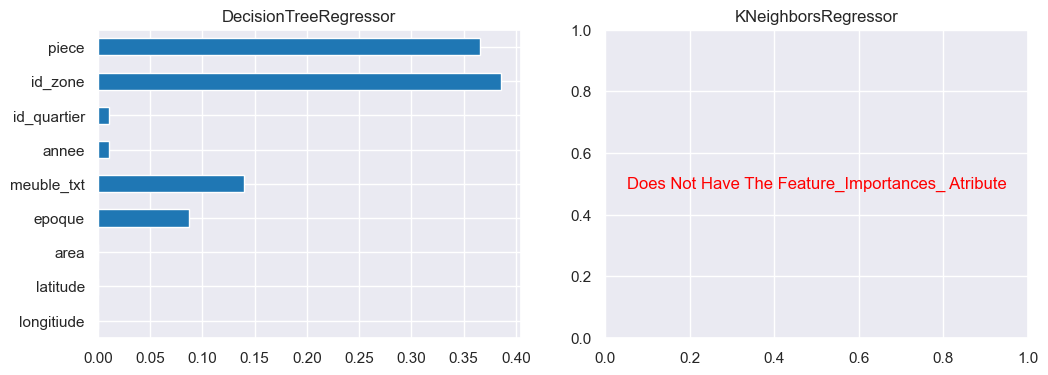

In [57]:
plot_feature_importances(   grid_search_estimators=grid_search_base_estimators, 
                            total_cols=2, 
                            figsize=(12, 4))

In [58]:
grid_search_neural_network_estimators = grid_search(models=neural_network_estimators,
                                                    param_grid=param_grid,
                                                    train_set=train_set,
                                                    Randomized_Search_cv=True,
                                                    relevant_estimators=relevant_estimators['neural_network_estimators'],
                                                    n_iter=10  )

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
  File "c:\Users\Brani\anaconda3\envs\paris_housing\l

In [59]:
summary_grid_search(grid_search_neural_network_estimators)

,best estimator,best score,best params,best index,scorer,number splits,refit time,multimetric,feature names in
models,,,,,,,,,
MLPRegressor,"MLPRegressor(alpha=0.001, hidden_layer_sizes=(...",1.276453,"{'solver': 'adam', 'learning_rate': 'constant'...",7,"make_scorer(mean_squared_error, greater_is_bet...",5,6.143743,False,"[longitiude, latitude, area, epoque, meuble_tx..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


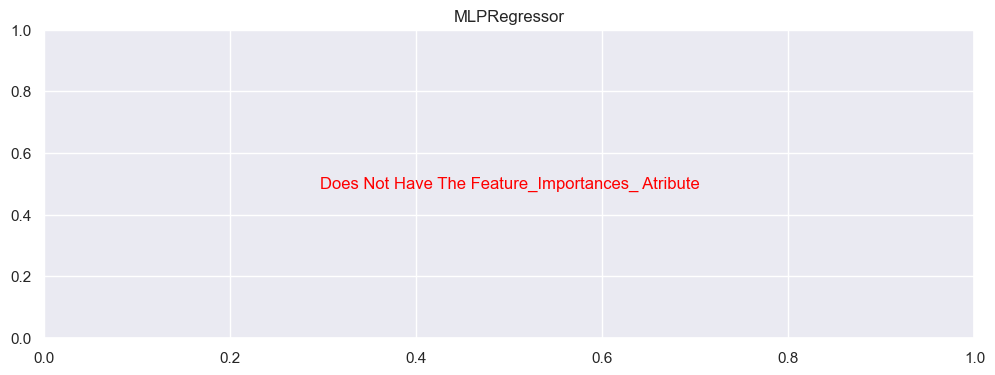

In [60]:
plot_feature_importances(   grid_search_estimators=grid_search_neural_network_estimators, 
                            total_cols=1, 
                            figsize=(12, 4))

In [61]:
grid_search_ensemble_estimators = grid_search(   models=ensemble_estimators,
                                                    param_grid=param_grid,
                                                    train_set=train_set,
                                                    Randomized_Search_cv=True,
                                                    relevant_estimators=relevant_estimators['ensemble_estimators'],
                                                    n_iter=10  )

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 20%|██        | 1/5 [00:44<02:57, 44.40s/it]c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 60%|██████    | 3/5 [01:26<00:50, 25.21s/it]c:\Users\Brani\anaconda3\envs\paris_housing\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-------------------------------------------------------------------

In [62]:
summary_grid_search(grid_search_ensemble_estimators)

,best estimator,best score,best params,best index,scorer,number splits,refit time,multimetric,feature names in
models,,,,,,,,,
AdaBoostRegressor,"(DecisionTreeRegressor(max_depth=30, random_st...",0.244154,"{'n_estimators': 200, 'learning_rate': 1.0, 'b...",0,"make_scorer(mean_squared_error, greater_is_bet...",5,5.969456,False,"[longitiude, latitude, area, epoque, meuble_tx..."
BaggingRegressor,"(DecisionTreeRegressor(max_depth=100, random_s...",0.306907,"{'n_estimators': 100, 'bootstrap_features': Fa...",9,"make_scorer(mean_squared_error, greater_is_bet...",5,2.878883,False,"[longitiude, latitude, area, epoque, meuble_tx..."
ExtraTreesRegressor,"(ExtraTreeRegressor(max_depth=100, min_samples...",0.235789,"{'n_estimators': 50, 'min_samples_split': 2, '...",6,"make_scorer(mean_squared_error, greater_is_bet...",5,0.639871,False,"[longitiude, latitude, area, epoque, meuble_tx..."
GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,0.380024,"{'subsample': 0.5, 'n_estimators': 200, 'min_s...",1,"make_scorer(mean_squared_error, greater_is_bet...",5,29.786497,False,"[longitiude, latitude, area, epoque, meuble_tx..."
RandomForestRegressor,"(DecisionTreeRegressor(max_depth=50, max_featu...",0.360077,"{'n_estimators': 100, 'min_samples_split': 10,...",8,"make_scorer(mean_squared_error, greater_is_bet...",5,2.167936,False,"[longitiude, latitude, area, epoque, meuble_tx..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


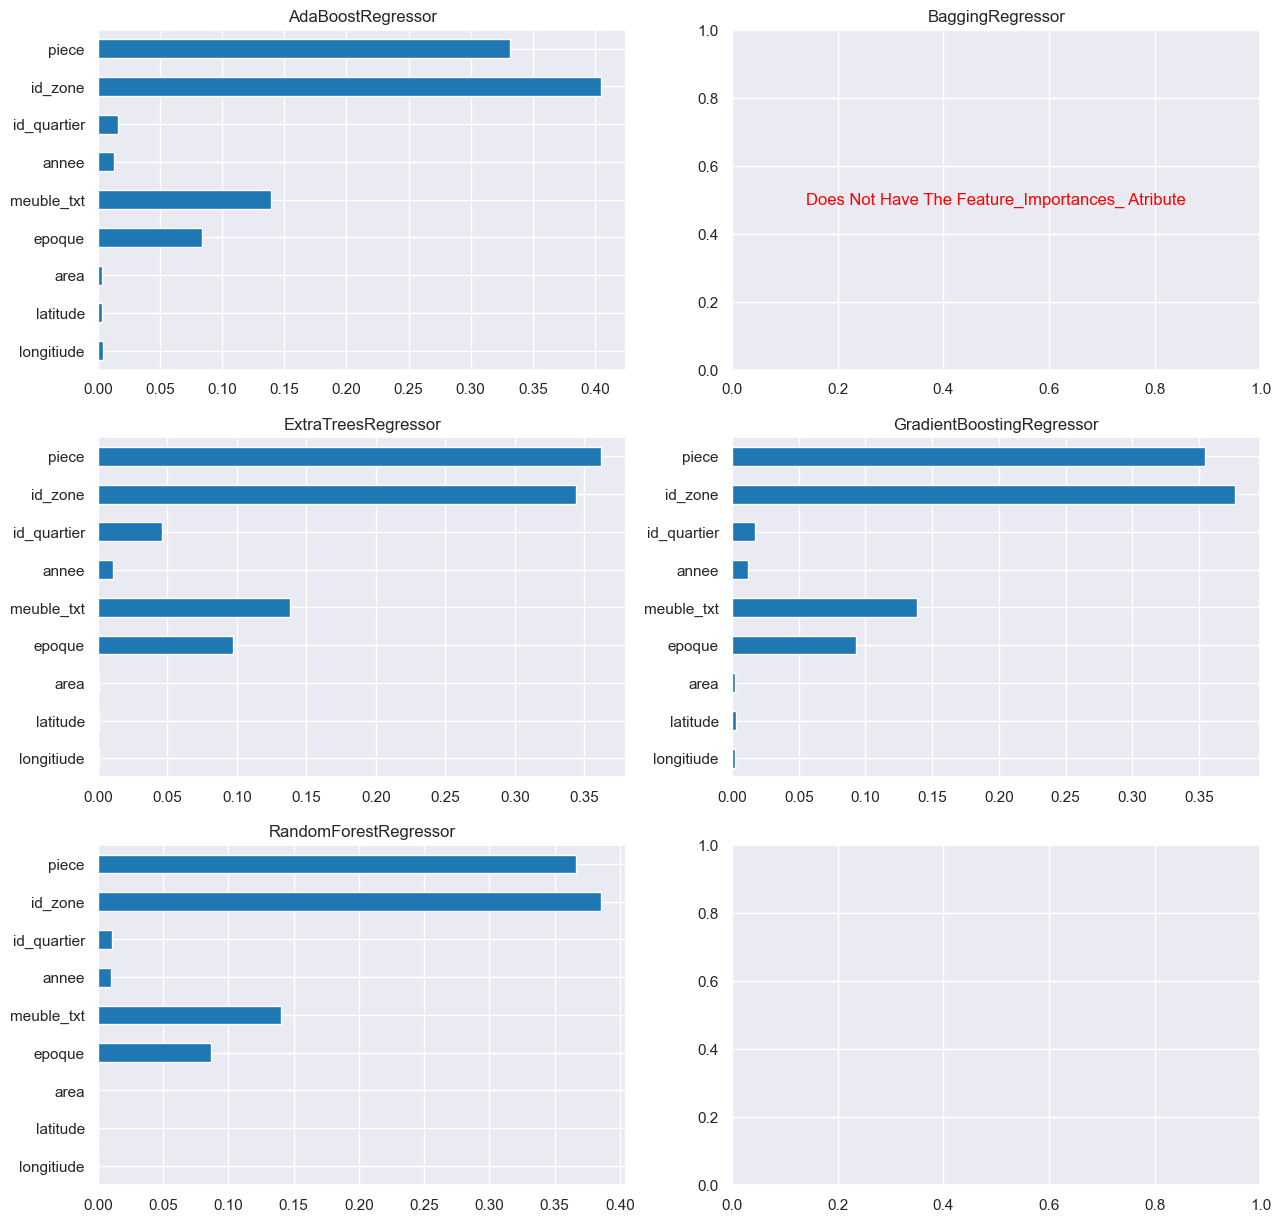

In [63]:
plot_feature_importances(   grid_search_estimators=grid_search_ensemble_estimators, 
                            total_cols=2, 
                            figsize=(15, 15)    )